# The Impact of Litigations on GHG Emissions
* "litigation" from [Graham Institute](https://climate-laws.org/legislation_and_policies), takes the value of 1 when the first case related to environmental laws was solved in a given year, independently of the result
* "rule of law" from World Bank
* Sample excludes the US, and includes all countries for which there has been at least a case with a resolution: 23 countries, mostly HI and MI countries

##### Load R packages

In [1]:
options(conflicts.policy = list(warn = FALSE))
library("dplyr")
library("estimatr")
library("fixest")
library("ggplot2")
library("gmm")
library("lmtest")
library("plm")
library("readr")
library("rstatix")

Loading required package: sandwich

Loading required package: zoo



##### Read data

In [2]:
my_data <- read_csv("../data/litigation.csv", show_col_types = 'FALSE')

##### Define Country_ID as numerical

In [3]:
# egen id = group(country)
my_data <- my_data %>% group_by(country) %>% mutate(id = cur_group_id())

In [4]:
# xtset id year
plm::is.pbalanced(my_data$id, my_data$year)

[1] TRUE

##### Creation of log values

In [5]:
my_data$lnghg <- log(my_data$ghg)
my_data$lngdp <- log(my_data$gdp)
my_data$lngdp2 <- log(my_data$gdp)^2
my_data$lnpopulation <- log(my_data$population)
my_data$lnlaw <- log(my_data$ruleoflaw)

##### Definition of High-Income and Middle-Income countries

In [6]:
HI <- my_data$country %in% c('BEL', 'AUS', 'CAN', 'CHE', 'DEU', 'ESP', 'EST', 'FIN', 
                             'FRA', 'GBR', 'GRC', 'HRV', 'ITA', 'LTU', 'LUX', 'NLD', 
                             'NOR', 'NZL', 'POL', 'PRT', 'SVK', 'SWE', 'ROU')


In [7]:
MI <- my_data$country %in% c('BGR', 'CRI', 'FJI', 'IND', 'KEN', 
                             'PAK', 'NPL', 'PHL', 'UKR')

### Figure 3. GHG Evolution of Emissions over Time. Whole Sample

In [8]:
d <- my_data %>%
  group_by(year) %>%
  summarize(mean_lnghg = mean(lnghg, na.rm = TRUE))

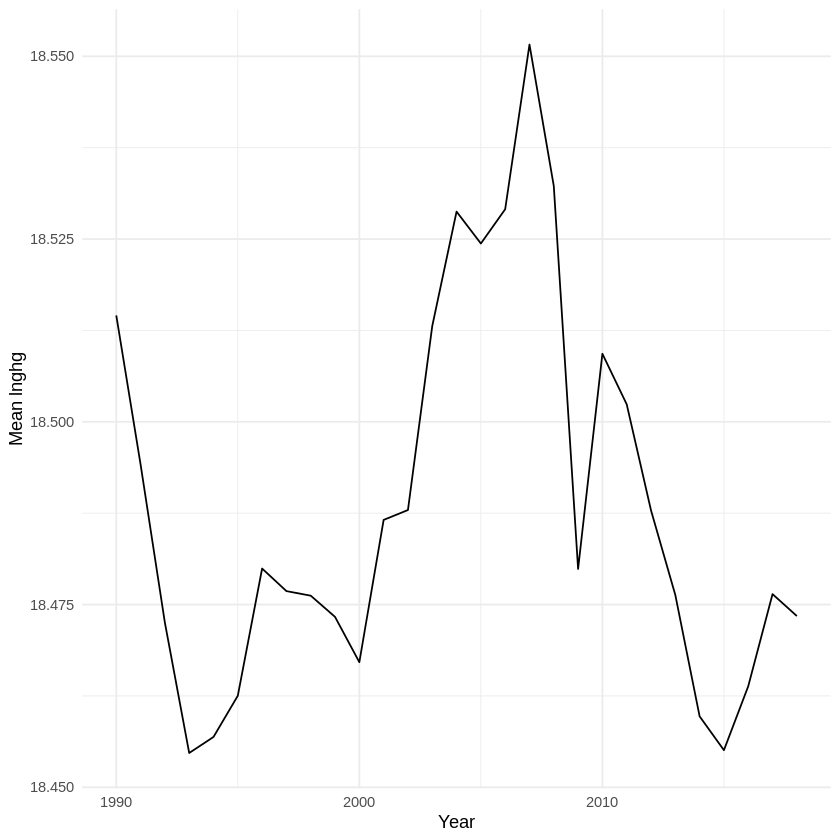

In [9]:
ggplot(d, aes(x = year, y = mean_lnghg)) +
  geom_line() +
  labs(x = "Year", y = "Mean lnghg") +
  theme_minimal()

### Figure 4. GHG Evolution of Emissions over Time. High-Income Countries

In [10]:
d <- data.frame(my_data$lnghg, my_data$year) %>% filter(HI == 1)
d <- d %>%
  group_by(my_data.year) %>%
  summarize(mean_lnghg = mean(my_data.lnghg, na.rm = TRUE))

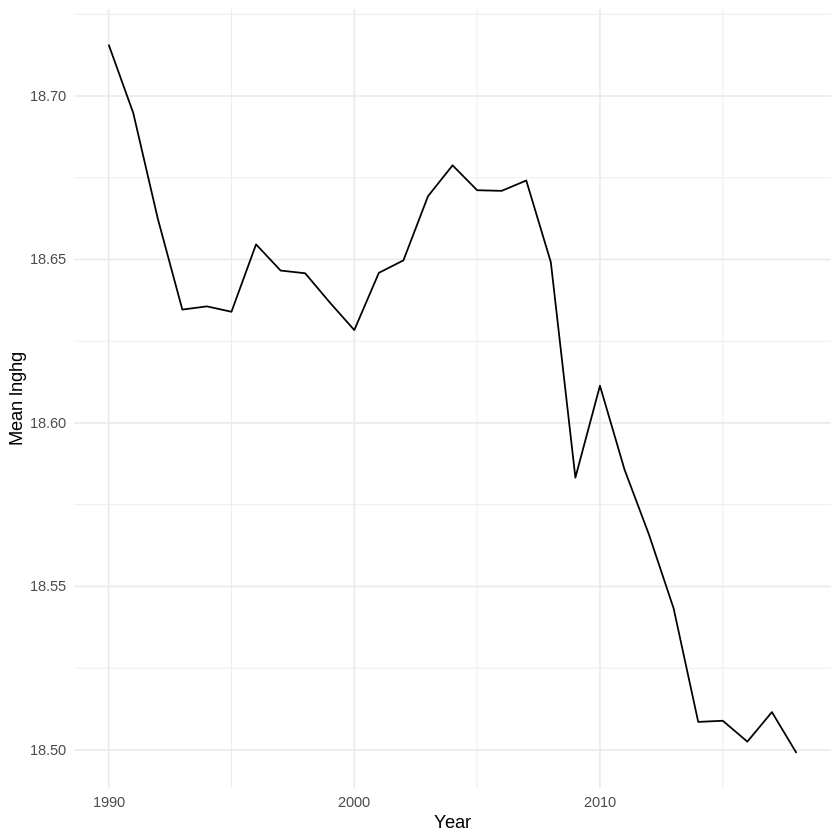

In [11]:
ggplot(d, aes(x = my_data.year, y = mean_lnghg)) +
  geom_line() +
  labs(x = "Year", y = "Mean lnghg") +
  theme_minimal()

###  Figure 5. GHG Evolution of Emissions over Time. Middle-Income Countries

In [12]:
d <- data.frame(my_data$lnghg, my_data$year) %>% filter(MI == 1)
d <- d %>%
  group_by(my_data.year) %>%
  summarize(mean_lnghg = mean(my_data.lnghg, na.rm = TRUE))

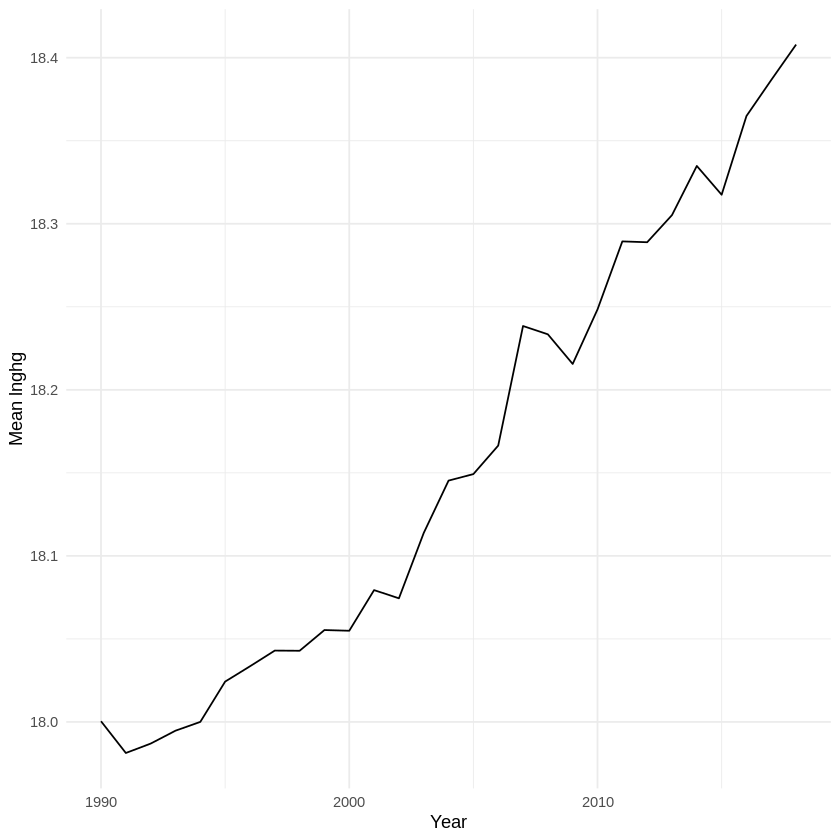

In [13]:
ggplot(d, aes(x = my_data.year, y = mean_lnghg)) +
  geom_line() +
  labs(x = "Year", y = "Mean lnghg") +
  theme_minimal()

### Table 2. Summary statistics

Panel A: Whole sample

In [14]:
# sum ghg gdp pop ruleoflaw
d <- data.frame(my_data$ghg, my_data$gdp, my_data$population, 
                my_data$ruleoflaw)
summary(d)

  my_data.ghg         my_data.gdp     my_data.population  my_data.ruleoflaw
 Min.   :1.820e+06   Min.   :  1617   Min.   :3.818e+05   Min.   : 14.36   
 1st Qu.:4.594e+07   1st Qu.: 12337   1st Qu.:5.103e+06   1st Qu.: 54.07   
 Median :8.563e+07   Median : 30423   Median :1.319e+07   Median : 78.85   
 Mean   :2.747e+08   Mean   : 30907   Mean   :6.250e+07   Mean   : 71.82   
 3rd Qu.:4.102e+08   3rd Qu.: 43346   3rd Qu.:4.649e+07   3rd Qu.: 94.87   
 Max.   :3.375e+09   Max.   :120648   Max.   :1.353e+09   Max.   :100.00   
                     NA's   :23                           NA's   :288      

Panel B: High-income countries

In [15]:
# sum ghg gdp pop ruleoflaw if HI==1
d <- data.frame(my_data$ghg, my_data$gdp, my_data$population, 
                my_data$ruleoflaw) %>% filter(HI == 1)
summary(d)

  my_data.ghg         my_data.gdp     my_data.population my_data.ruleoflaw
 Min.   :8.480e+06   Min.   : 10484   Min.   :  381850   Min.   : 14.36   
 1st Qu.:4.956e+07   1st Qu.: 28316   1st Qu.: 4969760   1st Qu.: 73.20   
 Median :1.058e+08   Median : 38212   Median :10514844   Median : 90.14   
 Mean   :2.449e+08   Mean   : 40093   Mean   :22272253   Mean   : 84.28   
 3rd Qu.:4.335e+08   3rd Qu.: 46890   3rd Qu.:38052979   3rd Qu.: 96.18   
 Max.   :1.160e+09   Max.   :120648   Max.   :82905782   Max.   :100.00   
                     NA's   :23                          NA's   :207      

Panel C: Middle-income countries

In [16]:
# sum ghg gdp pop ruleoflaw if MI==1
d <- data.frame(my_data$ghg, my_data$gdp, my_data$population, 
                my_data$ruleoflaw) %>% filter(MI == 1)
summary(d)

  my_data.ghg         my_data.gdp    my_data.population  my_data.ruleoflaw
 Min.   :1.820e+06   Min.   : 1617   Min.   :7.286e+05   Min.   :14.36    
 1st Qu.:2.705e+07   1st Qu.: 3316   1st Qu.:7.348e+06   1st Qu.:24.85    
 Median :6.708e+07   Median : 5607   Median :3.564e+07   Median :38.05    
 Mean   :3.507e+08   Mean   : 8240   Mean   :1.653e+08   Mean   :39.96    
 3rd Qu.:3.069e+08   3rd Qu.:11429   3rd Qu.:9.557e+07   3rd Qu.:53.07    
 Max.   :3.375e+09   Max.   :76323   Max.   :1.353e+09   Max.   :74.00    
                                                         NA's   :81       

### Summaries of log variables

Panel A: Whole sample

In [17]:
# sum lnghg lngdp lngdp2 lnpop lnlaw litigation
d <- data.frame(my_data$lnghg, my_data$lngdp, my_data$lngdp2, 
                my_data$lnpopulation, my_data$lnlaw)
summary(d)

 my_data.lnghg   my_data.lngdp    my_data.lngdp2   my_data.lnpopulation
 Min.   :14.41   Min.   : 7.388   Min.   : 54.58   Min.   :12.85       
 1st Qu.:17.64   1st Qu.: 9.420   1st Qu.: 88.74   1st Qu.:15.45       
 Median :18.27   Median :10.323   Median :106.56   Median :16.39       
 Mean   :18.49   Mean   : 9.986   Mean   :100.67   Mean   :16.52       
 3rd Qu.:19.83   3rd Qu.:10.677   3rd Qu.:114.00   3rd Qu.:17.65       
 Max.   :21.94   Max.   :11.701   Max.   :136.90   Max.   :21.03       
                 NA's   :23       NA's   :23                           
 my_data.lnlaw  
 Min.   :2.664  
 1st Qu.:3.990  
 Median :4.367  
 Mean   :4.184  
 3rd Qu.:4.553  
 Max.   :4.605  
 NA's   :288    

Panel B: High-income countries

In [18]:
# sum lnghg lngdp lngdp2 lnpop lnlaw litigation if HI==1
d <- data.frame(my_data$lnghg, my_data$lngdp, my_data$lngdp2, 
                my_data$lnpopulation, my_data$lnlaw) %>% filter(HI == 1)
summary(d)

 my_data.lnghg   my_data.lngdp    my_data.lngdp2  my_data.lnpopulation
 Min.   :15.95   Min.   : 9.258   Min.   : 85.7   Min.   :12.85       
 1st Qu.:17.72   1st Qu.:10.251   1st Qu.:105.1   1st Qu.:15.42       
 Median :18.48   Median :10.551   Median :111.3   Median :16.17       
 Mean   :18.62   Mean   :10.495   Mean   :110.4   Mean   :16.26       
 3rd Qu.:19.89   3rd Qu.:10.756   3rd Qu.:115.7   3rd Qu.:17.45       
 Max.   :20.87   Max.   :11.701   Max.   :136.9   Max.   :18.23       
                 NA's   :23       NA's   :23                          
 my_data.lnlaw  
 Min.   :2.664  
 1st Qu.:4.293  
 Median :4.501  
 Mean   :4.412  
 3rd Qu.:4.566  
 Max.   :4.605  
 NA's   :207    

Panel C: Middle-income countries

In [19]:
d <- data.frame(my_data$lnghg, my_data$lngdp, my_data$lngdp2, 
                my_data$lnpopulation, my_data$lnlaw) %>% filter(MI == 1)
summary(d)

 my_data.lnghg   my_data.lngdp    my_data.lngdp2   my_data.lnpopulation
 Min.   :14.41   Min.   : 7.388   Min.   : 54.58   Min.   :13.50       
 1st Qu.:17.11   1st Qu.: 8.106   1st Qu.: 65.71   1st Qu.:15.81       
 Median :18.02   Median : 8.632   Median : 74.51   Median :17.39       
 Mean   :18.16   Mean   : 8.730   Mean   : 76.77   Mean   :17.19       
 3rd Qu.:19.54   3rd Qu.: 9.344   3rd Qu.: 87.31   3rd Qu.:18.38       
 Max.   :21.94   Max.   :11.243   Max.   :126.40   Max.   :21.03       
                                                                       
 my_data.lnlaw  
 Min.   :2.664  
 1st Qu.:3.213  
 Median :3.639  
 Mean   :3.601  
 3rd Qu.:3.972  
 Max.   :4.304  
 NA's   :81     

### Table 3. Estimation Results for the Whole Sample

(1) OLS

In [20]:
# reg lnghg lngdp lngdp2 lnpopulation lnlaw litigation , robust
mod2 <-estimatr::lm_robust(lnghg ~ lngdp + lngdp2 + lnpopulation + lnlaw + litigation, data = my_data, se_type = "stata")
summary(mod2)


Call:
estimatr::lm_robust(formula = lnghg ~ lngdp + lngdp2 + lnpopulation + 
    lnlaw + litigation, data = my_data, se_type = "stata")

Standard error type:  HC1 

Coefficients:
              Estimate Std. Error t value  Pr(>|t|)  CI Lower  CI Upper  DF
(Intercept)  -14.22820    1.44345  -9.857 2.027e-21 -17.06273 -11.39367 633
lngdp          2.57894    0.30684   8.405 2.832e-16   1.97639   3.18150 633
lngdp2        -0.09856    0.01627  -6.056 2.387e-09  -0.13052  -0.06661 633
lnpopulation   0.99947    0.01131  88.391 0.000e+00   0.97727   1.02168 633
lnlaw          0.07553    0.06750   1.119 2.636e-01  -0.05702   0.20807 633
litigation    -0.04786    0.03651  -1.311 1.903e-01  -0.11955   0.02382 633

Multiple R-squared:  0.9221 ,	Adjusted R-squared:  0.9215 
F-statistic:  1930 on 5 and 633 DF,  p-value: < 2.2e-16

(2) TW-FE

In [21]:
# xtreg lnghg lngdp lngdp2 lnpopulation lnlaw litigation i.year, fe robust
modfe <- plm::plm(lnghg ~ lngdp + lngdp2 + lnpopulation + lnlaw + litigation,
                  index = c("id", "year"), model="within", effect='twoways', 
                  data = my_data)
summary(modfe, vcov=plm::vcovHC(modfe))

Twoways effects Within Model

Note: Coefficient variance-covariance matrix supplied: plm::vcovHC(modfe)

Call:
plm::plm(formula = lnghg ~ lngdp + lngdp2 + lnpopulation + lnlaw + 
    litigation, data = my_data, effect = "twoways", model = "within", 
    index = c("id", "year"))

Unbalanced Panel: n = 32, T = 19-20, N = 639

Residuals:
      Min.    1st Qu.     Median    3rd Qu.       Max. 
-0.2205138 -0.0372824 -0.0013006  0.0396659  0.1973966 

Coefficients:
              Estimate Std. Error t-value  Pr(>|t|)    
lngdp         2.457919   0.530010  4.6375 4.357e-06 ***
lngdp2       -0.096579   0.028671 -3.3685 0.0008057 ***
lnpopulation  1.429588   0.172184  8.3027 7.123e-16 ***
lnlaw        -0.069259   0.034396 -2.0135 0.0445173 *  
litigation   -0.034449   0.015895 -2.1673 0.0306194 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Total Sum of Squares:    9.9414
Residual Sum of Squares: 2.8429
R-Squared:      0.71404
Adj. R-Squared: 0.68706
F-statistic: 55.0814

(3) OLS

In [22]:
my_data$HITRUE_litigation <- HI * my_data$litigation
my_data$HIFALSE_litigation <- (1-HI) * my_data$litigation

In [23]:
# reg lnghg lngdp lngdp2 lnpopulation lnlaw HI#c.litigation, robust
mod2 <-estimatr::lm_robust(lnghg ~ lngdp + lngdp2 + lnpopulation + lnlaw + HITRUE_litigation + HIFALSE_litigation, 
                           data = my_data, se_type = "stata")
summary(mod2)


Call:
estimatr::lm_robust(formula = lnghg ~ lngdp + lngdp2 + lnpopulation + 
    lnlaw + HITRUE_litigation + HIFALSE_litigation, data = my_data, 
    se_type = "stata")

Standard error type:  HC1 

Coefficients:
                    Estimate Std. Error t value  Pr(>|t|)  CI Lower   CI Upper
(Intercept)        -13.99222    1.43584  -9.745 5.337e-21 -16.81181 -11.172628
lngdp                2.51508    0.30694   8.194 1.404e-15   1.91235   3.117820
lngdp2              -0.09540    0.01625  -5.870 7.057e-09  -0.12732  -0.063484
lnpopulation         0.99783    0.01136  87.809 0.000e+00   0.97551   1.020140
lnlaw                0.10214    0.06986   1.462 1.442e-01  -0.03504   0.239321
HITRUE_litigation   -0.07211    0.03908  -1.845 6.551e-02  -0.14886   0.004642
HIFALSE_litigation   0.08685    0.07225   1.202 2.298e-01  -0.05503   0.228719
                    DF
(Intercept)        632
lngdp              632
lngdp2             632
lnpopulation       632
lnlaw              632
HITRUE_litigation

(4) TW-FE

In [24]:
# xtreg lnghg lngdp lngdp2 lnpopulation lnlaw HI#c.litigation i.year, fe robust

modfe <- plm::plm(lnghg ~ lngdp + lngdp2 + lnpopulation + lnlaw + HITRUE_litigation + HIFALSE_litigation,
                  index = c("id", "year"), model="within", effect='twoways', data = my_data)
summary(modfe, vcov=plm::vcovHC(modfe))

Twoways effects Within Model

Note: Coefficient variance-covariance matrix supplied: plm::vcovHC(modfe)

Call:
plm::plm(formula = lnghg ~ lngdp + lngdp2 + lnpopulation + lnlaw + 
    HITRUE_litigation + HIFALSE_litigation, data = my_data, effect = "twoways", 
    model = "within", index = c("id", "year"))

Unbalanced Panel: n = 32, T = 19-20, N = 639

Residuals:
       Min.     1st Qu.      Median     3rd Qu.        Max. 
-0.22312652 -0.03797838 -0.00071444  0.03988400  0.20408018 

Coefficients:
                    Estimate Std. Error t-value  Pr(>|t|)    
lngdp               2.326192   0.502026  4.6336 4.438e-06 ***
lngdp2             -0.090108   0.027112 -3.3236 0.0009445 ***
lnpopulation        1.430751   0.175797  8.1387 2.433e-15 ***
lnlaw              -0.069230   0.035009 -1.9775 0.0484574 *  
HITRUE_litigation  -0.040771   0.018069 -2.2564 0.0244154 *  
HIFALSE_litigation -0.010867   0.035185 -0.3088 0.7575470    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’

### Table 4. Results with interactions and Instrumental Variables

(1) Interaction

In [25]:
# xtreg lnghg lngdp lngdp2 lnpop c.lnlaw#i.litigation i.year, fe robust
my_data$lnlaw_litigation <- my_data$lnlaw * my_data$litigation
my_data$lnlaw_no_litigation <- my_data$lnlaw * (1 - my_data$litigation)
modintfe <- plm::plm(lnghg ~ lngdp + lngdp2 + lnpopulation + lnlaw_litigation + lnlaw_no_litigation,
                  index = c("id", "year"), model="within", effect='twoways', 
                  data = my_data)
summary(modintfe, vcov=plm::vcovHC(modintfe))

Twoways effects Within Model

Note: Coefficient variance-covariance matrix supplied: plm::vcovHC(modintfe)

Call:
plm::plm(formula = lnghg ~ lngdp + lngdp2 + lnpopulation + lnlaw_litigation + 
    lnlaw_no_litigation, data = my_data, effect = "twoways", 
    model = "within", index = c("id", "year"))

Unbalanced Panel: n = 32, T = 19-20, N = 639

Residuals:
       Min.     1st Qu.      Median     3rd Qu.        Max. 
-0.22040147 -0.03764012 -0.00093908  0.04017032  0.19973460 

Coefficients:
                     Estimate Std. Error t-value  Pr(>|t|)    
lngdp                2.418571   0.526581  4.5930 5.358e-06 ***
lngdp2              -0.094537   0.028513 -3.3156 0.0009713 ***
lnpopulation         1.432805   0.174048  8.2322 1.209e-15 ***
lnlaw_litigation    -0.077690   0.034333 -2.2629 0.0240114 *  
lnlaw_no_litigation -0.069425   0.034344 -2.0215 0.0436883 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Total Sum of Squares:    9.9414
Residual Sum of Squares: 

(2) UMI

In [26]:
# gen UMI=0
# quietly replace UMI=1 if gdp<12700
# xtreg lnghg lngdp lngdp2 lnpop lnlaw UMI#c.litigation i.year, fe  robust
UMI <- my_data$gdp<12700
my_data$UMITRUE_litigation <- UMI * my_data$litigation
my_data$UMIFALSE_litigation <- (1-UMI) * my_data$litigation
modfe <- plm::plm(lnghg ~ lngdp + lngdp2 + lnpopulation + lnlaw + UMIFALSE_litigation + UMITRUE_litigation,
                  index = c("id", "year"), model="within", effect='twoways', data = my_data)
summary(modfe, vcov=plm::vcovHC(modfe))

Twoways effects Within Model

Note: Coefficient variance-covariance matrix supplied: plm::vcovHC(modfe)

Call:
plm::plm(formula = lnghg ~ lngdp + lngdp2 + lnpopulation + lnlaw + 
    UMIFALSE_litigation + UMITRUE_litigation, data = my_data, 
    effect = "twoways", model = "within", index = c("id", "year"))

Unbalanced Panel: n = 32, T = 19-20, N = 639

Residuals:
      Min.    1st Qu.     Median    3rd Qu.       Max. 
-0.2203247 -0.0373364 -0.0013339  0.0402970  0.1959788 

Coefficients:
                     Estimate Std. Error t-value  Pr(>|t|)    
lngdp                2.491482   0.482862  5.1598 3.396e-07 ***
lngdp2              -0.098276   0.026059 -3.7713  0.000179 ***
lnpopulation         1.431401   0.176223  8.1227 2.739e-15 ***
lnlaw               -0.069170   0.034136 -2.0263  0.043190 *  
UMIFALSE_litigation -0.033164   0.017360 -1.9104  0.056577 .  
UMITRUE_litigation  -0.041630   0.050386 -0.8262  0.409022    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 

(3) IV-GMM

In [27]:
# xi:xtivreg2 lnghg lngdp lngdp2 lnpop lnlaw i.year (litigation=l(-2/-1).fillingdate), fe gmm
my_data$fillingdate_lag1 <- lag(fillingdate ~ id + year, 1, my_data)
my_data$fillingdate_lag2 <- lag(fillingdate ~ id + year, 2, my_data)
formula <- lnghg ~ lngdp + lngdp2 + lnpopulation + lnlaw | id + year | litigation ~ fillingdate_lag1 + fillingdate_lag2
model <- feols(formula, data = my_data, panel.id = ~ id + year)
summary(model)

NOTE: 291 observations removed because of NA values (RHS: 289, IV: 0/67).



TSLS estimation, Dep. Var.: lnghg, Endo.: litigation, Instr.: fillingdate_lag1, fillingdate_lag2
Second stage: Dep. Var.: lnghg
Observations: 637 
Fixed-effects: id: 32,  year: 20
Standard-errors: Clustered (id) 
                Estimate Std. Error  t value   Pr(>|t|)    
fit_litigation -0.055054   0.023711 -2.32189 2.6980e-02 *  
lngdp           2.444743   0.528340  4.62722 6.2342e-05 ***
lngdp2         -0.096068   0.028600 -3.35904 2.0857e-03 ** 
lnpopulation    1.400789   0.175656  7.97463 5.2837e-09 ***
lnlaw          -0.068023   0.036182 -1.88001 6.9532e-02 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.066603     Adj. R2: 0.997822
                 Within R2: 0.714878
F-test (1st stage), litigation: stat = 246.2     , p < 2.2e-16 , on 2 and 611 DoF.
                    Wu-Hausman: stat =   2.24981 , p = 0.134175, on 1 and 580 DoF.
                        Sargan: stat =   0.085556, p = 0.769905, on 1 DoF.

### Table 5. Results without EIT, for EU Countries and by Type of Litigation Decision

(1) EIT-FE

In [28]:
# gen EIT=1
# local non_EIT_countries "BGR HRV EST LTU POL ROU SVK"
# foreach country of local non_EIT_countries {
#     quietly replace EIT = 0 if country == "`country'"
# }
my_data$EIT <- 1 - my_data$country %in% c('BGR', 'HRV', 'EST', 'LTU', 
                                         'POL', 'ROU', 'SVK')

In [29]:
#xtreg lnghg lngdp lngdp2 lnpop lnlaw litigation i.year if EIT==1,fe robust
modfe <- plm::plm(lnghg ~ lngdp + lngdp2 + lnpopulation + lnlaw + litigation,
                  index = c("id", "year"), model="within", effect='twoways', 
                  data = my_data, subset = (EIT == 1))
summary(modfe, vcov=plm::vcovHC(modfe))

Twoways effects Within Model

Note: Coefficient variance-covariance matrix supplied: plm::vcovHC(modfe)

Call:
plm::plm(formula = lnghg ~ lngdp + lngdp2 + lnpopulation + lnlaw + 
    litigation, data = my_data, subset = (EIT == 1), effect = "twoways", 
    model = "within", index = c("id", "year"))

Unbalanced Panel: n = 25, T = 19-20, N = 499

Residuals:
       Min.     1st Qu.      Median     3rd Qu.        Max. 
-0.20955690 -0.03779646 -0.00018644  0.03752626  0.19077956 

Coefficients:
              Estimate Std. Error t-value  Pr(>|t|)    
lngdp         2.454991   0.514293  4.7735 2.452e-06 ***
lngdp2       -0.095832   0.027885 -3.4367 0.0006436 ***
lnpopulation  1.524427   0.256251  5.9490 5.427e-09 ***
lnlaw        -0.083100   0.028252 -2.9414 0.0034357 ** 
litigation   -0.045327   0.018604 -2.4364 0.0152198 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Total Sum of Squares:    8.9567
Residual Sum of Squares: 2.1285
R-Squared:      0.76235
Adj. R-Square

(2) EU-FE

In [30]:
# gen EU=1
# local non_EU_countries "CAN CRI FJI IND KEN NZL PAK PHL AUS NPL"
# foreach country of local non_EU_countries {
#     quietly replace EU = 0 if country == "`country'"
# }
my_data$EU <- 1 - my_data$country %in% c('CAN', 'CRI', 'FJI', 'IND', 'KEN', 
                                         'NZL', 'PAK', 'PHL', 'AUS', 'NPL')

In [31]:
# xtreg lnghg lngdp lngdp2 lnpop lnlaw litigation i.year if EU==1,fe robust
modfe <- plm::plm(lnghg ~ lngdp + lngdp2 + lnpopulation + lnlaw + litigation,
                  index = c("id", "year"), model="within", effect='twoways', 
                  data = my_data, subset = (EU == 1))
summary(modfe, vcov=plm::vcovHC(modfe))

Twoways effects Within Model

Note: Coefficient variance-covariance matrix supplied: plm::vcovHC(modfe)

Call:
plm::plm(formula = lnghg ~ lngdp + lngdp2 + lnpopulation + lnlaw + 
    litigation, data = my_data, subset = (EU == 1), effect = "twoways", 
    model = "within", index = c("id", "year"))

Balanced Panel: n = 22, T = 20, N = 440

Residuals:
     Min.   1st Qu.    Median   3rd Qu.      Max. 
-0.244197 -0.031778  0.001365  0.034044  0.183984 

Coefficients:
              Estimate Std. Error t-value  Pr(>|t|)    
lngdp        -3.258660   0.733305 -4.4438 1.150e-05 ***
lngdp2        0.182269   0.036587  4.9818 9.448e-07 ***
lnpopulation  0.387635   0.196115  1.9766   0.04879 *  
lnlaw        -0.124096   0.025096 -4.9449 1.130e-06 ***
litigation   -0.029101   0.015155 -1.9202   0.05556 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Total Sum of Squares:    2.0901
Residual Sum of Squares: 1.4604
R-Squared:      0.30128
Adj. R-Squared: 0.22147
F-statistic: 18

(3) By litigation decision type

In [32]:
# gen ncl=0  
# local ncl_countries "AUS BEL EST DEU GRC NZL NOR GBR CHE UKR PTR KEN FJI"
# foreach country of local ncl_countries {
#     quietly replace ncl = 1 if country == "`country'"
# }
# gen ncllitig=ncl*litigation
my_data$ncl_country <- my_data$country %in% c('AUS', 'BEL', 'EST', 'DEU', 
                                              'GRC', 'NZL', 'NOR', 'GBR', 
                                              'CHE', 'UKR', 'PTR', 'KEN', 'FJI')
my_data$ncllitig = my_data$ncl_country * my_data$litigation

In [33]:
# xtreg lnghg lngdp lngdp2 lnpop lnlaw litigation ncllitig i.year,fe robust
modfe <- plm::plm(lnghg ~ lngdp + lngdp2 + lnpopulation + lnlaw + litigation + ncllitig,
                  index = c("id", "year"), model="within", effect='twoways', 
                  data = my_data)
summary(modfe, vcov=plm::vcovHC(modfe))

Twoways effects Within Model

Note: Coefficient variance-covariance matrix supplied: plm::vcovHC(modfe)

Call:
plm::plm(formula = lnghg ~ lngdp + lngdp2 + lnpopulation + lnlaw + 
    litigation + ncllitig, data = my_data, effect = "twoways", 
    model = "within", index = c("id", "year"))

Unbalanced Panel: n = 32, T = 19-20, N = 639

Residuals:
       Min.     1st Qu.      Median     3rd Qu.        Max. 
-0.22205675 -0.03762914 -0.00094733  0.03830963  0.20042100 

Coefficients:
              Estimate Std. Error t-value  Pr(>|t|)    
lngdp         2.462322   0.537634  4.5799 5.693e-06 ***
lngdp2       -0.096572   0.028894 -3.3423 0.0008843 ***
lnpopulation  1.432205   0.171190  8.3662 4.423e-16 ***
lnlaw        -0.068673   0.034206 -2.0077 0.0451420 *  
litigation   -0.037795   0.019700 -1.9185 0.0555346 .  
ncllitig      0.010011   0.037821  0.2647 0.7913447    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Total Sum of Squares:    9.9414
Residual Sum of Squares

(4) Kyoto

In [34]:
# gen kyoto=0
# quietly replace kyoto=1 if HI==1&year>=2008
my_data$kyoto = HI & my_data$year>=2008

In [35]:
# xtreg lnghg lngdp lngdp2 lnpop lnlaw litigation  kyoto i.year,fe robust
modfe <- plm::plm(lnghg ~ lngdp + lngdp2 + lnpopulation + lnlaw + litigation + kyoto,
                  index = c("id", "year"), model="within", effect='twoways', 
                  data = my_data)
summary(modfe, vcov=plm::vcovHC(modfe))

Twoways effects Within Model

Note: Coefficient variance-covariance matrix supplied: plm::vcovHC(modfe)

Call:
plm::plm(formula = lnghg ~ lngdp + lngdp2 + lnpopulation + lnlaw + 
    litigation + kyoto, data = my_data, effect = "twoways", model = "within", 
    index = c("id", "year"))

Unbalanced Panel: n = 32, T = 19-20, N = 639

Residuals:
       Min.     1st Qu.      Median     3rd Qu.        Max. 
-0.22000112 -0.03793309 -0.00033378  0.03980540  0.21152883 

Coefficients:
              Estimate Std. Error t-value  Pr(>|t|)    
lngdp         2.004498   0.460574  4.3522 1.592e-05 ***
lngdp2       -0.074809   0.025029 -2.9889  0.002918 ** 
lnpopulation  1.395733   0.179600  7.7713 3.534e-14 ***
lnlaw        -0.061383   0.038946 -1.5761  0.115548    
litigation   -0.026994   0.015283 -1.7663  0.077869 .  
kyotoTRUE    -0.059297   0.038211 -1.5518  0.121249    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Total Sum of Squares:    9.9414
Residual Sum of Squares: 2